In [ ]:
%matplotlib inline
# Import the pyplot module of Matplotlib as plt
import matplotlib.pyplot as plt
import sklearn
# Import pandas under the abbreviation 'pd'
import pandas as pd

# Import NumPy under the abbreviation 'np'
import numpy as np
from google.colab import files
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import statsmodels.api as sm
import scipy
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import folium
from folium.plugins import HeatMap
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
import geopandas as gpd
import warnings

In [ ]:
water_quality = pd.read_csv('/content/renamed_has_socio.csv')

In [ ]:
uploaded = files.upload()
file_name = ""
for name in uploaded.keys():
  file_name = name
water_quality = pd.read_csv(name)
water_quality.head()

Saving only_chem_encoded.csv to only_chem_encoded (1).csv


,location,latitude,longitude,method,measurement,county,clustered_value,month,year,mean_income,...,Strontium,Uranium-234/235/238,Chemical oxygen demand,Ammonia-nitrogen,Inorganic nitrogen (nitrate and nitrite) ***retired***use Nitrate + Nitrite,Nitrogen,Dissolved oxygen (DO),Total volatile solids,Solids,Hardness
0,0,39.921110,-96.93712,0,1.3000,0,3,7,2000,47026,...,False,False,False,False,False,False,False,False,False,False
1,1,38.738810,-95.67175,0,3.0000,1,0,1,2000,56134,...,False,False,False,False,False,False,False,False,False,False
2,2,38.630430,-95.33303,0,0.1100,2,0,11,2000,56365,...,False,False,False,False,False,False,False,False,False,False
3,3,37.023598,-94.72069,0,190.0000,3,0,2,2000,49620,...,False,False,False,False,False,False,False,False,False,False
4,4,37.170180,-96.95398,0,0.0028,4,2,6,2000,52501,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
water_quality.describe()

,location,latitude,longitude,method,chemical,measurement,county,clustered_value,month,year,mean_income,z_score,socio_status
count,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000,612784.000000
mean,258.316906,38.428742,-97.005287,0.339815,16.996555,62.335232,32.910252,1.361005,6.554654,2007.607798,56437.563895,0.057200,-0.143400
std,261.072654,0.873530,1.634371,0.759748,10.506047,240.244324,23.438061,1.164317,3.186012,4.839642,9578.410210,1.207287,0.832348
min,0.000000,37.003750,-102.013260,0.000000,0.000000,-0.040000,0.000000,0.000000,1.000000,2000.000000,40963.000000,-2.171674,-1.000000
25%,81.000000,37.652860,-97.995620,0.000000,8.000000,0.084000,12.000000,0.000000,4.000000,2003.000000,50052.000000,-0.651817,-1.000000
50%,177.000000,38.477440,-96.858010,0.000000,16.000000,1.100000,30.000000,1.000000,7.000000,2007.000000,54202.000000,-0.192320,0.000000
75%,331.000000,39.080560,-95.676680,0.000000,26.000000,21.000000,50.000000,2.000000,9.000000,2011.000000,59996.000000,0.442744,1.000000
max,1210.000000,40.000230,-94.611380,9.000000,46.000000,45000.000000,96.000000,3.000000,12.000000,2022.000000,138482.000000,5.683050,1.000000


In [ ]:
def basic_statistics(df):
    # Separate numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if len(numerical_cols) == 0:
        return "No numerical columns found in the dataset."

    # Calculate statistics
    stats_df = df[numerical_cols].describe().T

    # Add additional statistics
    stats_df['median'] = df[numerical_cols].median()
    stats_df['variance'] = df[numerical_cols].var()
    stats_df['skewness'] = df[numerical_cols].skew()
    stats_df['kurtosis'] = df[numerical_cols].kurtosis()
    stats_df['missing'] = df[numerical_cols].isna().sum()
    stats_df['missing_percent'] = (df[numerical_cols].isna().sum() / len(df)) * 100

    return stats_df

def correlation_analysis(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if len(numerical_cols) < 2:
        return "Need at least two numerical columns for correlation analysis."

    corr_matrix = df[numerical_cols].corr()
    return corr_matrix

def plot_correlation_heatmap(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if len(numerical_cols) < 2:
        print("Need at least two numerical columns for correlation heatmap.")
        return

    plt.figure(figsize=(12, 10))
    correlation = df[numerical_cols].corr()
    mask = np.triu(correlation)
    sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm',
                linewidths=0.5, annot_kws={"size": 8})
    plt.title('Feature Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()

def categorical_analysis(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(categorical_cols) == 0:
        return "No categorical columns found in the dataset."

    cat_stats = {}
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        unique_count = df[col].nunique()
        missing = df[col].isna().sum()
        missing_percent = (missing / len(df)) * 100

        cat_stats[col] = {
            'unique_values': unique_count,
            'missing': missing,
            'missing_percent': missing_percent,
            'top_5_values': value_counts.nlargest(5).to_dict()
        }

    return cat_stats

def plot_categorical_charts(df, max_categories=10):
    """Plot charts for categorical features."""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(categorical_cols) == 0:
        print("No categorical columns to visualize.")
        return

    for col in categorical_cols:
        value_counts = df[col].value_counts().nlargest(max_categories)

        if df[col].nunique() > 50:
            print(f"Skipping {col} - has {df[col].nunique()} unique values (likely not categorical)")
            continue

        plt.figure(figsize=(12, 6))
        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f'Distribution of {col}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

def plot_distributions(df, bins=30):
    """Plot histograms and boxplots for numerical features."""
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if len(numerical_cols) == 0:
        print("No numerical columns to visualize.")
        return

    for col in numerical_cols:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        sns.histplot(df[col].dropna(), kde=True, bins=bins, ax=ax1)
        ax1.set_title(f'Distribution of {col}')

        #sns.boxplot(x=df[col].dropna(), ax=ax2)
        #ax2.set_title(f'Boxplot of {col}')

        #plt.tight_layout()
        plt.show()


def perform_normality_test(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if len(numerical_cols) == 0:
        return "No numerical columns for normality test."

    normality_results = {}
    for col in numerical_cols:
        data = df[col].dropna()
        if len(data) > 5000:
            data = data.sample(5000, random_state=42)
        elif len(data) < 3:
            normality_results[col] = {"error": "Not enough data points for test"}
            continue

        try:
            stat, p_value = scipy.stats.shapiro(data)
            normality_results[col] = {
                "statistic": stat,
                "p_value": p_value,
                "normal_distribution": p_value > 0.05
            }
        except Exception as e:
            normality_results[col] = {"error": str(e)}

    return pd.DataFrame(normality_results).T

def feature_summary(df):
    """Provide a quick summary of the dataset features."""
    num_rows, num_cols = df.shape
    dtypes_counts = df.dtypes.value_counts().to_dict()
    dtypes = df.dtypes.to_dict()
    missing_cols = df.columns[df.isna().any()].tolist()

    dtype_dict = {str(k): v for k, v in dtypes_counts.items()}

    column_info = []
    for col in df.columns:
        col_type = str(df[col].dtype)
        missing_count = df[col].isna().sum()
        missing_percent = (missing_count / len(df)) * 100
        unique_count = df[col].nunique()
        unique_percent = (unique_count / len(df)) * 100 if len(df) > 0 else 0

        column_info.append({
            'column': col,
            'type': col_type,
            'missing': missing_count,
            'missing_percent': missing_percent,
            'unique_values': unique_count,
            'unique_percent': unique_percent
        })

    column_df = pd.DataFrame(column_info)

    summary = {
        "rows": num_rows,
        "columns": num_cols,
        "column_types": dtype_dict,
        "columns_with_missing_values": missing_cols,
        "detailed_column_info": column_df
    }

    return summary

def plot_missing_data(df):
    """Visualize missing data in the dataset."""
    plt.figure(figsize=(10, 6))

    sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
    plt.title('Missing Value Patterns', fontsize=14)
    plt.xlabel('Features')
    plt.ylabel('Observations')
    plt.tight_layout()
    plt.show()

    missing_percent = df.isna().mean().sort_values(ascending=False) * 100

    if missing_percent.max() > 0:
        plt.figure(figsize=(12, 6))
        missing_percent.plot(kind='bar')
        plt.title('Percentage of Missing Values by Feature', fontsize=14)
        plt.xlabel('Features')
        plt.ylabel('Missing Value %')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values in the dataset!")

def analyze_outliers(df):
    """Analyze outliers in numerical features using IQR method."""
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if len(numerical_cols) == 0:
        return "No numerical columns for outlier analysis."

    outlier_stats = {}

    for col in numerical_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

        outlier_stats[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return pd.DataFrame(outlier_stats).T

# Statistical Analysis Report

## Dataset Summary

**Number of rows:** 265686

**Number of columns:** 13

**Column types:**

- int64: 7

- float64: 6

### Detailed Column Information

,column,type,missing,missing_percent,unique_values,unique_percent
0,location,int64,0,0.0,1192,0.448650
1,latitude,float64,0,0.0,1137,0.427949
2,longitude,float64,0,0.0,1135,0.427196
3,method,int64,0,0.0,9,0.003387
4,chemical,int64,0,0.0,21,0.007904
5,measurement,float64,0,0.0,1654,0.622539
6,county,int64,0,0.0,97,0.036509
7,clustered_value,int64,0,0.0,4,0.001506
8,month,int64,0,0.0,12,0.004517
9,year,int64,0,0.0,19,0.007151


## Missing Data Analysis

**No missing values found in the dataset.**

## Numerical Statistics

,count,mean,std,min,25%,50%,75%,max,median,variance,skewness,kurtosis,missing,missing_percent
location,265686.0,263.586565,262.108011,0.000000,83.000000,180.00000,340.000000,1210.000000,180.00000,6.870061e+04,1.603615,1.905556,0,0.0
latitude,265686.0,38.418844,0.872167,37.003750,37.641644,38.47142,39.060870,40.000230,38.47142,7.606758e-01,-0.042429,-1.108211,0,0.0
longitude,265686.0,-96.963931,1.623553,-102.013260,-97.973890,-96.73034,-95.671750,-94.611380,-96.73034,2.635925e+00,-0.665635,-0.008473,0,0.0
method,265686.0,0.350387,0.711580,0.000000,0.000000,0.00000,0.000000,9.000000,0.00000,5.063455e-01,2.273850,8.850926,0,0.0
chemical,265686.0,19.239527,9.954184,3.000000,12.000000,19.00000,26.000000,45.000000,19.00000,9.908577e+01,0.050560,-0.934408,0,0.0
measurement,265686.0,82.178759,270.384798,0.001100,0.250000,5.70000,58.000000,45000.000000,5.70000,7.310794e+04,46.181305,6140.887729,0,0.0
county,265686.0,32.950280,23.555731,0.000000,12.000000,30.00000,50.000000,96.000000,30.00000,5.548725e+02,0.517029,-0.718512,0,0.0
clustered_value,265686.0,1.350707,1.169748,0.000000,0.000000,1.00000,2.000000,3.000000,1.00000,1.368311e+00,0.152531,-1.463737,0,0.0
month,265686.0,6.549171,3.199061,1.000000,4.000000,7.00000,9.000000,12.000000,7.00000,1.023399e+01,-0.034055,-1.009650,0,0.0
year,265686.0,2007.777730,4.813415,2000.000000,2004.000000,2008.00000,2012.000000,2021.000000,2008.00000,2.316896e+01,0.090274,-1.069756,0,0.0


## Distribution of Numerical Features

0            3
1            5
2           11
3           12
4           13
          ... 
265681    1203
265682    1210
265683    1209
265684    1206
265685    1203
Name: location, Length: 265686, dtype: int64


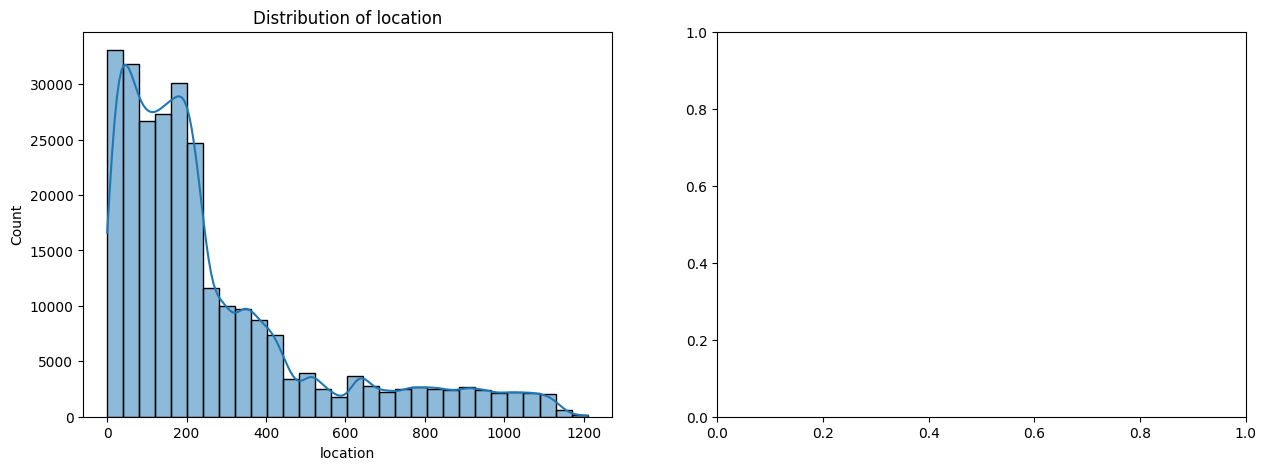

0         37.023598
1         38.505250
2         37.216280
3         39.687600
4         38.842330
            ...    
265681    38.434610
265682    38.163690
265683    38.877045
265684    38.486057
265685    38.434610
Name: latitude, Length: 265686, dtype: float64


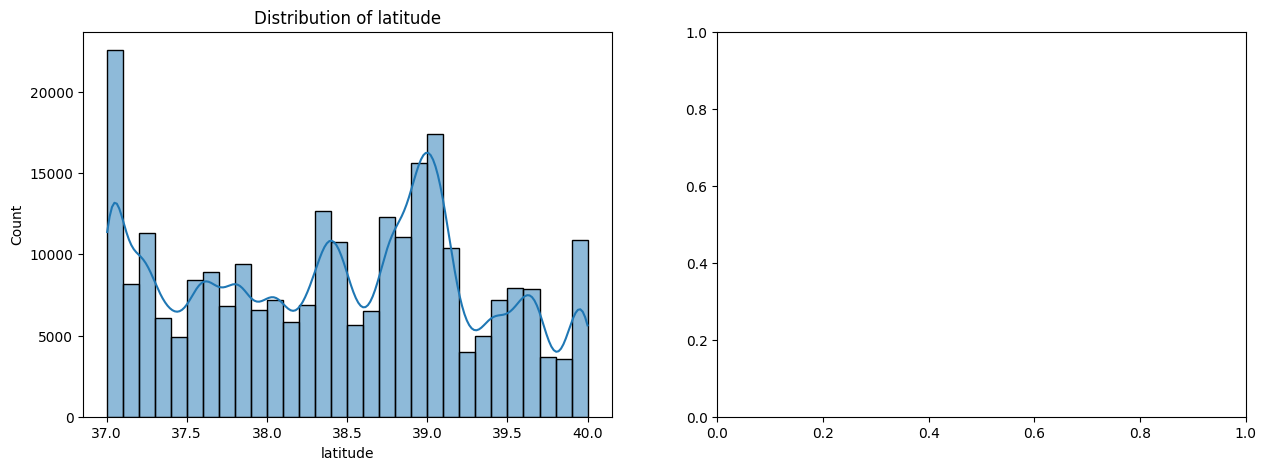

0        -94.720690
1        -94.853190
2        -97.348360
3        -96.638720
4        -94.612470
            ...    
265681   -96.549280
265682   -97.097920
265683   -97.523170
265684   -96.691025
265685   -96.549280
Name: longitude, Length: 265686, dtype: float64


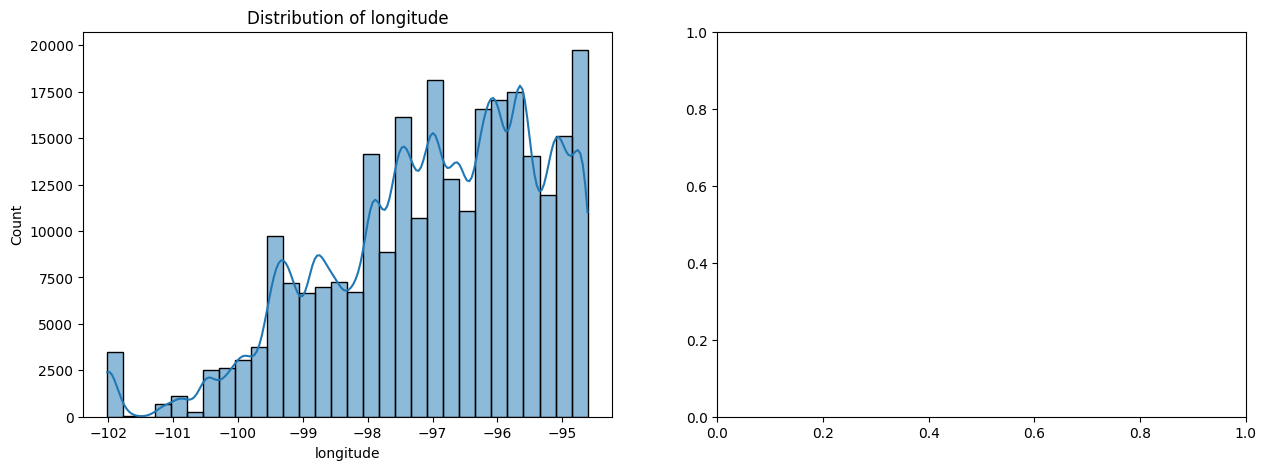

0         0
1         0
2         0
3         0
4         0
         ..
265681    8
265682    8
265683    8
265684    8
265685    8
Name: method, Length: 265686, dtype: int64


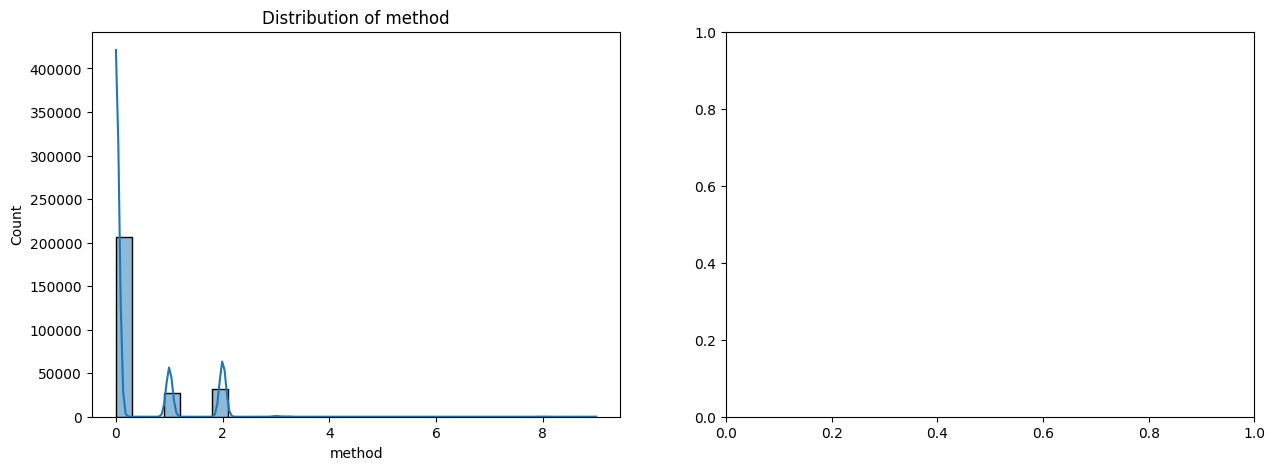

0          3
1          5
2         11
3         12
4          5
          ..
265681    26
265682    18
265683    35
265684    19
265685    19
Name: chemical, Length: 265686, dtype: int64


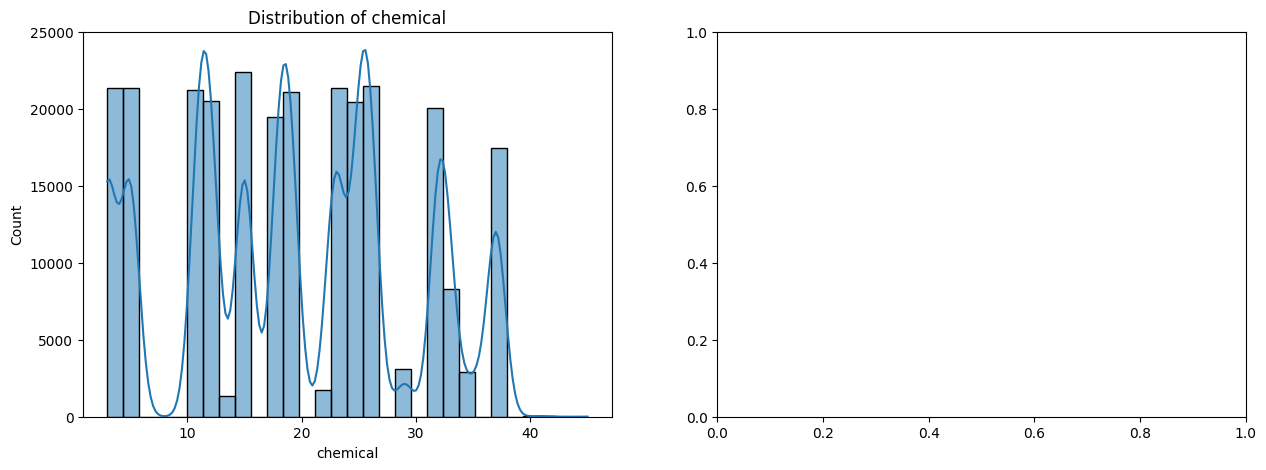

0         190.000
1           4.600
2           1.200
3           0.120
4          14.000
           ...   
265681      4.490
265682      0.313
265683      0.370
265684     12.400
265685      6.290
Name: measurement, Length: 265686, dtype: float64


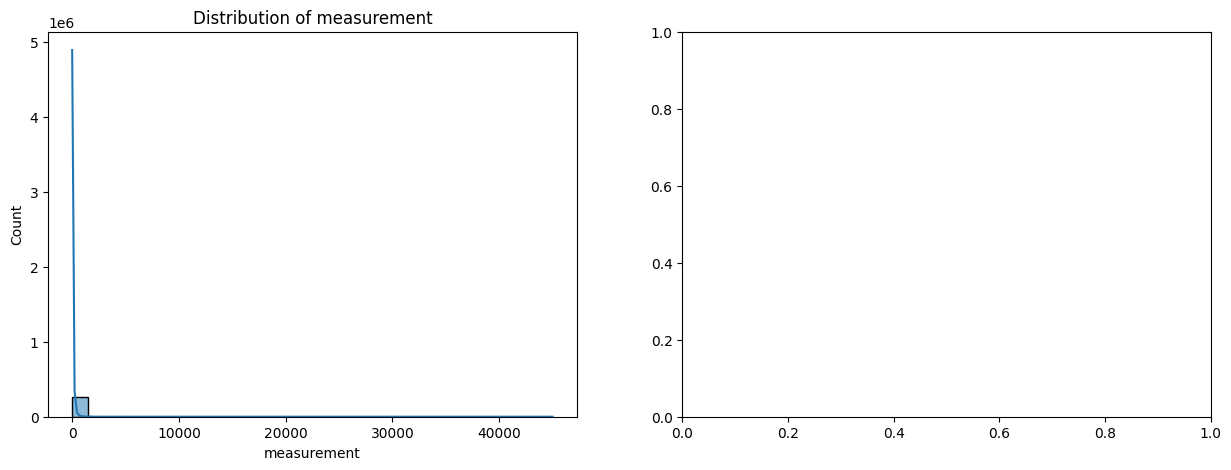

0          3
1          5
2          9
3         10
4         11
          ..
265681    34
265682    81
265683    33
265684    34
265685    34
Name: county, Length: 265686, dtype: int64


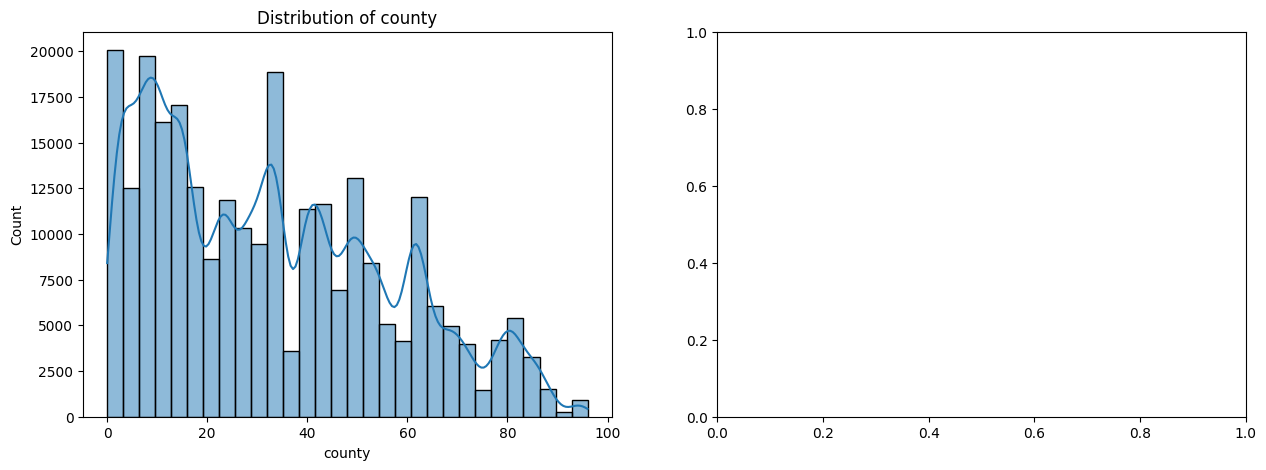

0         0
1         0
2         2
3         3
4         0
         ..
265681    3
265682    2
265683    3
265684    3
265685    3
Name: clustered_value, Length: 265686, dtype: int64


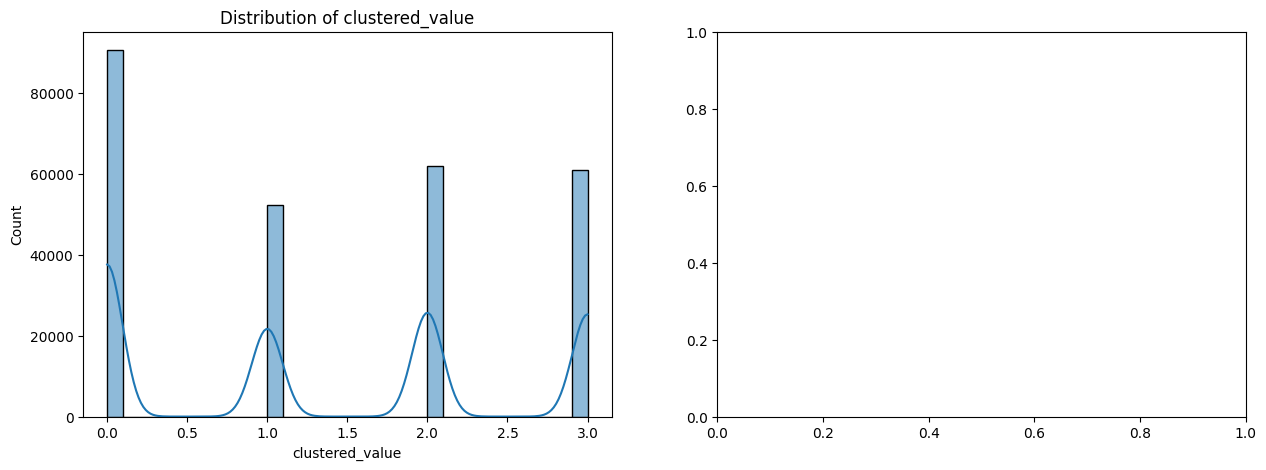

0         2
1         9
2         6
3         3
4         9
         ..
265681    5
265682    5
265683    5
265684    9
265685    5
Name: month, Length: 265686, dtype: int64


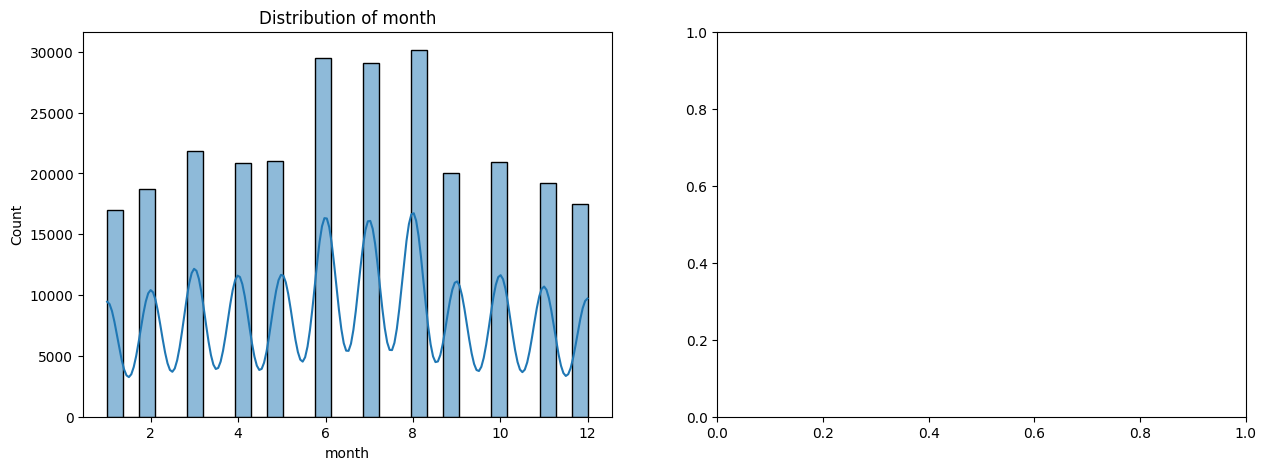

0         2000
1         2000
2         2000
3         2000
4         2000
          ... 
265681    2021
265682    2021
265683    2021
265684    2021
265685    2021
Name: year, Length: 265686, dtype: int64


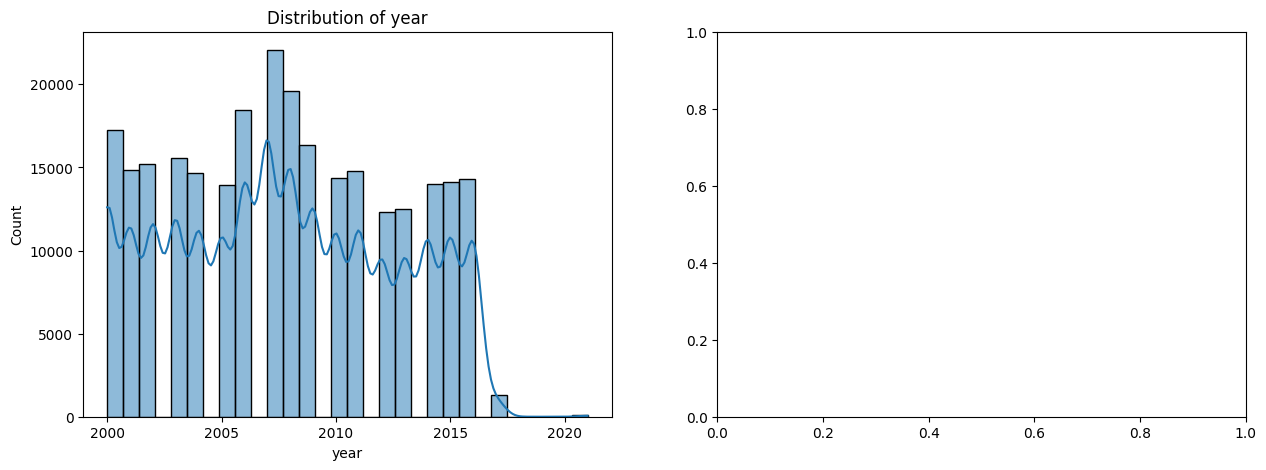

0         49620.0
1         68997.0
2         58980.0
3         49992.0
4         95218.0
           ...   
265681    67761.0
265682    71861.0
265683    71419.0
265684    67761.0
265685    67761.0
Name: mean_income, Length: 265686, dtype: float64


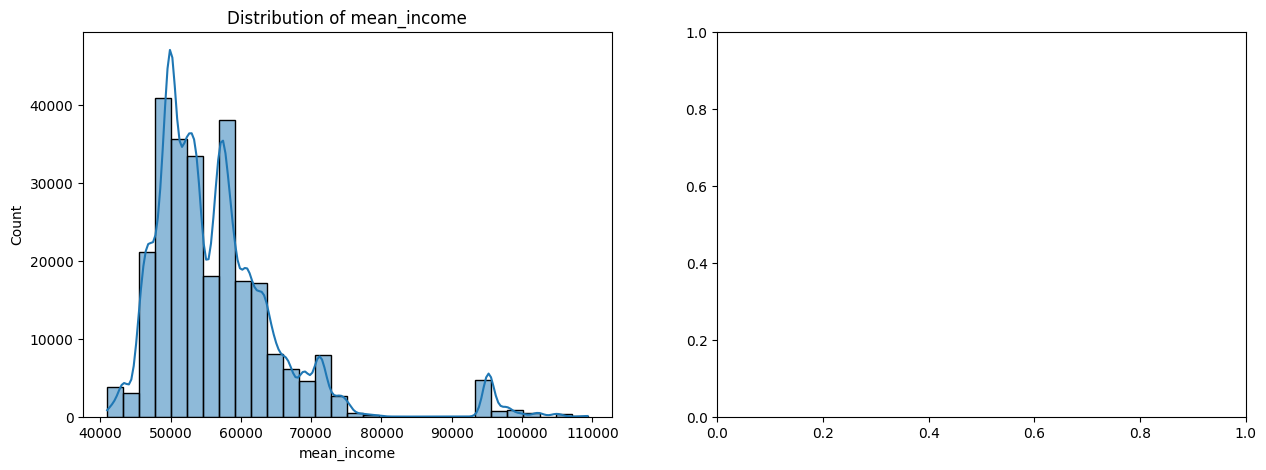

0        -0.651817
1         1.896462
2         0.579121
3        -0.602895
4         5.344798
            ...   
265681   -0.479971
265682   -0.104758
265683   -0.145208
265684   -0.479971
265685   -0.479971
Name: z_score, Length: 265686, dtype: float64


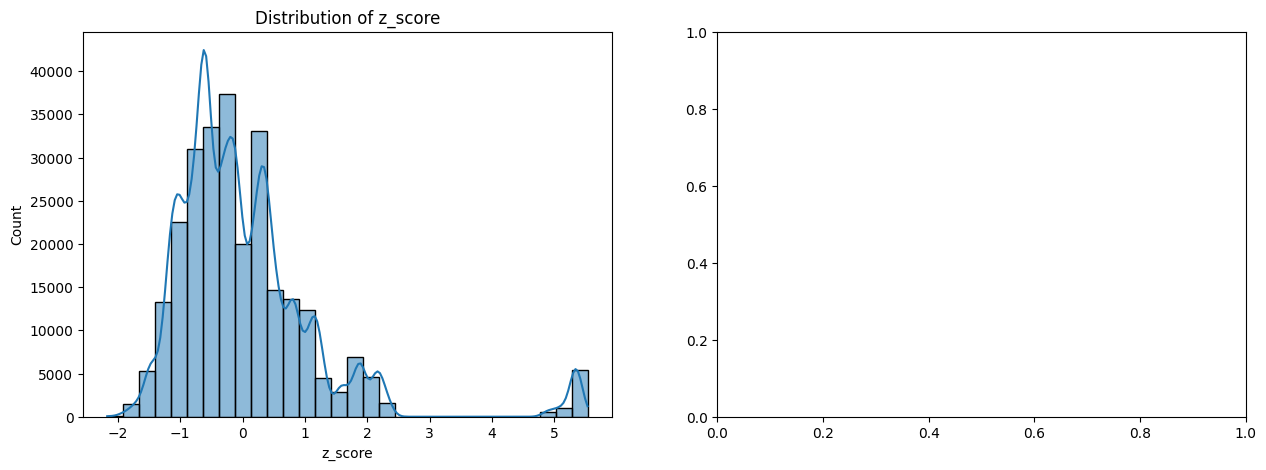

0        -1.0
1         1.0
2         1.0
3        -1.0
4         1.0
         ... 
265681   -1.0
265682    0.0
265683    0.0
265684   -1.0
265685   -1.0
Name: socio_status, Length: 265686, dtype: float64


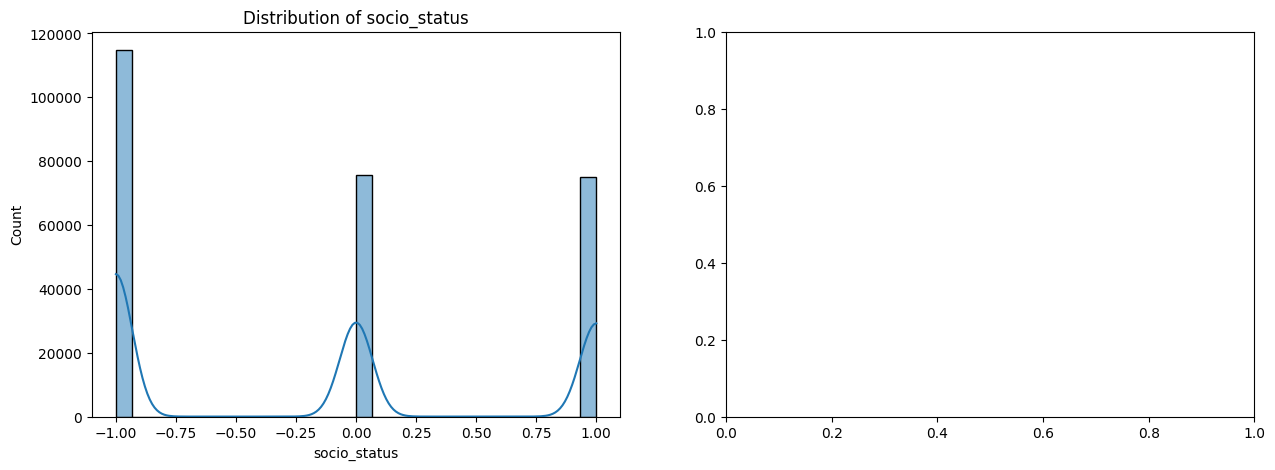

## Outlier Analysis

KeyboardInterrupt: 

In [ ]:
from IPython.display import display, Markdown, HTML
display(Markdown("# Statistical Analysis Report"))

display(Markdown("## Dataset Summary"))
summary = feature_summary(water_quality)

display(Markdown(f"**Number of rows:** {summary['rows']}"))
display(Markdown(f"**Number of columns:** {summary['columns']}"))
display(Markdown("**Column types:**"))
for dtype, count in summary['column_types'].items():
    display(Markdown(f"- {dtype}: {count}"))

display(Markdown("### Detailed Column Information"))
display(summary['detailed_column_info'])

display(Markdown("## Missing Data Analysis"))
missing_count = water_quality.isna().sum().sum()
if missing_count > 0:
    display(Markdown(f"**Total missing values:** {missing_count}"))
    display(Markdown(f"**Columns with missing values:** {len(summary['columns_with_missing_values'])}"))
    plot_missing_data(water_quality)
else:
    display(Markdown("**No missing values found in the dataset.**"))

display(Markdown("## Numerical Statistics"))
stats = basic_statistics(water_quality)
if isinstance(stats, str):
    display(Markdown(stats))
else:
    display(stats)

display(Markdown("## Distribution of Numerical Features"))
plot_distributions(water_quality)

display(Markdown("## Outlier Analysis"))
outliers = analyze_outliers(water_quality)
if isinstance(outliers, str):
    display(Markdown(outliers))
else:
    display(outliers)

display(Markdown("## Correlation Analysis"))
corr = correlation_analysis(water_quality)
if isinstance(corr, str):
    display(Markdown(corr))
else:
    display(corr.style.background_gradient(cmap='coolwarm'))
    plot_correlation_heatmap(water_quality)

display(Markdown("## Categorical Analysis"))
cat_stats = categorical_analysis(water_quality)
if isinstance(cat_stats, str):
    display(Markdown(cat_stats))
else:
    for col, stats in cat_stats.items():
        display(Markdown(f"### Column: {col}"))
        display(Markdown(f"- **Unique values:** {stats['unique_values']}"))
        display(Markdown(f"- **Missing:** {stats['missing']} ({stats['missing_percent']:.2f}%)"))
        display(Markdown("- **Top 5 values:**"))
        for value, count in stats['top_5_values'].items():
            display(Markdown(f"  - {value}: {count}"))

    plot_categorical_charts(water_quality)

display(Markdown("## Normality Tests (Shapiro-Wilk)"))
normality = perform_normality_test(water_quality)
if isinstance(normality, str):
    display(Markdown(normality))
else:
    display(normality)

display(Markdown("## Analysis Complete!"))

In [ ]:
chemical_dummies = pd.get_dummies(water_quality['chemical'], prefix='chemical', drop_first=True)
#county_dummies = pd.get_dummies(water_quality['county'], prefix='county', drop_first=True)
#cluster_dummies = pd.get_dummies(water_quality['clustered_value'], prefix='cluster', drop_first=True)

#water_quality_encoded = pd.concat([#For each model, we performed at least 30 tests on the untuned versions and 20 on the tuned.
#    water_quality.drop(['chemical', 'county', 'clustered_value'], axis=1),
#    chemical_dummies, county_dummies, cluster_dummies
#], axis=1)

water_quality_encoded = pd.concat([
    water_quality.drop(['chemical'], axis=1),
    chemical_dummies
], axis=1)

In [ ]:
water_quality_encoded = water_quality
X = water_quality_encoded.drop(['mean_income', 'socio_status', 'z_score', 'clustered_value', 'latitude', 'longitude', 'county', 'location'], axis=1)
y = water_quality_encoded['mean_income']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
selector = SelectKBest(f_regression, k=4)
X_new = selector.fit(X_train, y_train)

f_scores = pd.DataFrame({'Feature': X.columns, 'F_score': selector.scores_, 'P_value': selector.pvalues_})

f_scores_sorted = f_scores.sort_values(by='P_value', ascending=True)

print("Feature Importances (from lowest to highest P-Value):\n")
i = 1
for idx, row in f_scores_sorted.iterrows():
    print("{}. {}: \t\t{:.4f} \t{:.4f}".format(i, row['Feature'], row['F_score'], row['P_value']))
    i += 1


Feature Importances (from lowest to highest P-Value):

1. method: 		3592.9637 	0.0000
2. year: 		17777.6174 	0.0000
3. Dissolved oxygen (DO): 		1441.2776 	0.0000
4. Chemical oxygen demand: 		788.7984 	0.0000
5. Total volatile solids: 		711.3998 	0.0000
6. Inorganic nitrogen (nitrate and nitrite) ***retired***use Nitrate + Nitrite: 		374.9421 	0.0000
7. Total solids: 		296.3641 	0.0000
8. Uranium-234/235/238: 		232.0517 	0.0000
9. Nitrogen: 		201.0628 	0.0000
10. Hardness: 		178.8335 	0.0000
11. Total dissolved solids: 		156.7858 	0.0000
12. measurement: 		103.7267 	0.0000
13. Orthophosphate: 		77.6855 	0.0000
14. Ammonia-nitrogen: 		67.8246 	0.0000
15. Solids: 		54.8144 	0.0000
16. Vanadium: 		43.3273 	0.0000
17. Biochemical oxygen demand/ standard conditions: 		35.1602 	0.0000
18. Nitrite: 		34.8029 	0.0000
19. Total suspended solids: 		25.7897 	0.0000
20. Lead: 		21.6316 	0.0000
21. Molybdenum: 		18.2709 	0.0000
22. Chromium: 		9.3164 	0.0023
23. Iron: 		8.5580 	0.0034
24. Bromide: 	

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)
rf.fit(X_train, y_train)
rf_scores = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})

In [ ]:
import numpy as np
import pandas as pd

# Assuming `rf` is your trained RandomForestRegressor and `X` is your DataFrame
# Step 1: Get importances from each tree
all_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Step 2: Compute the standard deviation across trees
std_devs = np.std(all_importances, axis=0)

# Step 3: Add to your rf_scores DataFrame
rf_scores = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_,
    'StdDev': std_devs
})


In [ ]:
print("Columns in DataFrame:", rf_scores.columns.tolist())

Columns in DataFrame: ['Feature', 'Importance', 'StdDev']


In [ ]:
import joblib

# Save the model to a file
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
# Load the model to a variable
rf = joblib.load('random_forest_model.pkl')

In [ ]:
rf_scores.to_csv('random_forest_feature_importance.csv', index=False)

In [ ]:
rf_scores = pd.read_csv('random_forest_feature_importance.csv')
rf_scores.head()

,Feature,Importance,StdDev
0,Johnson County,0.501749,0.002107
1,Butler County,0.067701,0.000669
2,year,0.057774,0.000791
3,longitude,0.056841,0.003072
4,latitude,0.052616,0.002345


In [ ]:
rf_scores_sorted = rf_scores.sort_values(by='Importance', ascending=False)
rf_scores_sorted = rf_scores_sorted.dropna()
print("Feature Importances (from highest to lowest):\n")
i = 1
for idx, row in rf_scores_sorted.iterrows():
    print(f"{i}. {row['Feature']}: \t\t{row['Importance']:.4f}, {row['StdDev']:.4f}")
    i += 1

Feature Importances (from highest to lowest):

1. measurement: 		0.5052, 0.0361
2. year: 		0.1570, 0.0291
3. month: 		0.1057, 0.0299
4. method: 		0.0479, 0.0019
5. Iron: 		0.0086, 0.0010
6. Aluminum: 		0.0081, 0.0009
7. Chloride: 		0.0079, 0.0013
8. Sodium: 		0.0076, 0.0011
9. Sulfate: 		0.0069, 0.0011
10. Phosphorus: 		0.0069, 0.0013
11. Magnesium: 		0.0069, 0.0011
12. Manganese: 		0.0069, 0.0009
13. Silica: 		0.0068, 0.0011
14. Nitrate: 		0.0063, 0.0011
15. Kjeldahl nitrogen: 		0.0061, 0.0008
16. Total suspended solids: 		0.0057, 0.0009
17. Nickel: 		0.0057, 0.0007
18. Copper: 		0.0057, 0.0008
19. Potassium: 		0.0056, 0.0010
20. Arsenic: 		0.0055, 0.0009
21. Fluoride: 		0.0055, 0.0010
22. Strontium: 		0.0054, 0.0009
23. Oxygen: 		0.0053, 0.0007
24. Barium: 		0.0051, 0.0009
25. Organic carbon: 		0.0050, 0.0007
26. Calcium: 		0.0045, 0.0008
27. Boron: 		0.0044, 0.0008
28. Hardness/ Ca/ Mg: 		0.0042, 0.0007
29. Zinc: 		0.0036, 0.0007
30. Lead: 		0.0035, 0.0006
31. Selenium: 		0.0035, 0.

In [ ]:
pip install forestci

  Preparing metadata (setup.py) ... done
  Created wheel for forestci: filename=forestci-0.7-py3-none-any.whl size=12016 sha256=85f8a5168b58027adbadac7f3a7c8dc7f21aed9b60d598b14b26da6a2874bf55
  Stored in directory: /root/.cache/pip/wheels/f3/8e/ad/88ee48b8b9bd2ded707a0979332029ad6d183a6a84eb574ce5
Successfully built forestci


In [ ]:
def plot_bar_graph_with_errors(df, threshold=0.0004):
    # Filter out low-importance features
    df = df[df['Importance'] >= threshold]

    if df.empty:
        print(f"No features with importance >= {threshold}.")
        return

    # Sort by Importance descending
    df = df.sort_values(by='Importance', ascending=False)

    # Extract columns
    names = df['Feature']
    values = df['Importance']
    errors = df['StdDev'] if 'StdDev' in df.columns else np.zeros(len(df))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(names, values, yerr=errors, capsize=5)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance for Predicting Mean Income')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


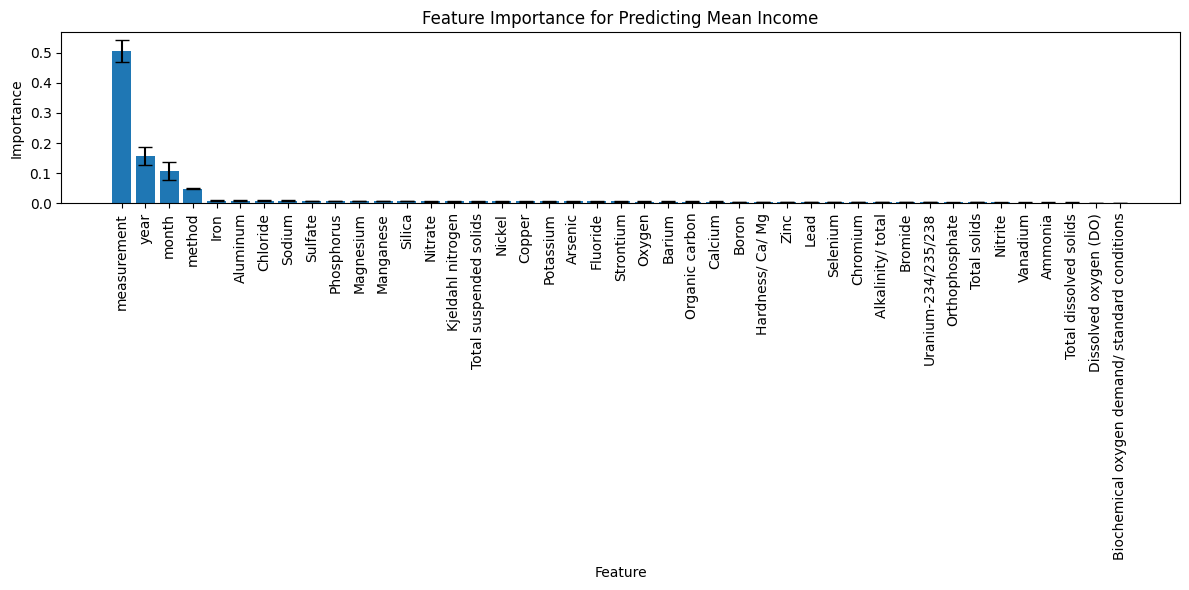

In [ ]:
plot_bar_graph_with_errors(rf_scores_sorted)

In [ ]:
target_chemical = 'mean_income'
predictors_chemical = [col for col in water_quality_encoded.columns if col not in ['mean_income', 'Inorganic nitrogen (nitrate and nitrite) ***retired***use Nitrate + Nitrite']]

print(f"PREDICTORS CHEMICAL: \n\n{predictors_chemical}")

formula_chemical = f"{target_chemical} ~ {' + '.join(predictors_chemical)}"
model_chemical = ols(formula=formula_chemical, data=water_quality_encoded).fit()
print(model_chemical.summary())

PREDICTORS CHEMICAL: 

['location', 'latitude', 'longitude', 'method', 'measurement', 'county', 'clustered_value', 'month', 'year', 'z_score', 'socio_status', 'Manganese', 'Total suspended solids', 'Phosphorus', 'Hardness/ Ca/ Mg', 'Chromium', 'Silica', 'Total dissolved solids', 'Magnesium', 'Calcium', 'Biochemical oxygen demand/ standard conditions', 'Nitrate', 'Iron', 'Barium', 'Kjeldahl nitrogen', 'Potassium', 'Oxygen', 'Boron', 'Bromide', 'Fluoride', 'Sodium', 'Sulfate', 'Vanadium', 'Nickel', 'Alkalinity/ total', 'Lead', 'Copper', 'Chloride', 'Organic carbon', 'Arsenic', 'Ammonia', 'Zinc', 'Selenium', 'Aluminum', 'Total solids', 'Orthophosphate', 'Nitrite', 'Molybdenum', 'Strontium', 'Uranium-234/235/238', 'Chemical oxygen demand', 'Ammonia-nitrogen', 'Nitrogen', 'Dissolved oxygen (DO)', 'Total volatile solids', 'Solids', 'Hardness']


PatsyError: numbers besides '0' and '1' are only allowed with **
    mean_income ~ location + latitude + longitude + method + measurement + county + clustered_value + month + year + z_score + socio_status + Manganese + Total suspended solids + Phosphorus + Hardness/ Ca/ Mg + Chromium + Silica + Total dissolved solids + Magnesium + Calcium + Biochemical oxygen demand/ standard conditions + Nitrate + Iron + Barium + Kjeldahl nitrogen + Potassium + Oxygen + Boron + Bromide + Fluoride + Sodium + Sulfate + Vanadium + Nickel + Alkalinity/ total + Lead + Copper + Chloride + Organic carbon + Arsenic + Ammonia + Zinc + Selenium + Aluminum + Total solids + Orthophosphate + Nitrite + Molybdenum + Strontium + Uranium-234/235/238 + Chemical oxygen demand + Ammonia-nitrogen + Nitrogen + Dissolved oxygen (DO) + Total volatile solids + Solids + Hardness
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ^^^

,location,latitude,longitude,method,measurement,county,clustered_value,month,year,mean_income,z_score,socio_status
location,1.000000,0.023318,0.040882,0.767800,-0.016829,0.192723,0.015946,0.022215,0.286995,0.115491,0.064024,0.037997
latitude,0.023318,1.000000,-0.047145,0.018763,-0.006240,0.205589,0.255037,0.000385,0.004899,0.105528,0.105985,0.094340
longitude,0.040882,-0.047145,1.000000,0.052496,-0.110308,-0.260933,-0.306015,0.015412,-0.006944,0.204536,0.209001,0.080163
method,0.767800,0.018763,0.052496,1.000000,-0.020339,0.105393,-0.032155,0.041939,0.214646,0.087608,0.045135,0.006941
measurement,-0.016829,-0.006240,-0.110308,-0.020339,1.000000,0.019286,0.025210,-0.001686,-0.002731,-0.015642,-0.016016,-0.008578
county,0.192723,0.205589,-0.260933,0.105393,0.019286,1.000000,0.049379,0.000231,0.032530,-0.159927,-0.168940,-0.084918
clustered_value,0.015946,0.255037,-0.306015,-0.032155,0.025210,0.049379,1.000000,-0.009110,0.029611,-0.083688,-0.088734,0.076310
month,0.022215,0.000385,0.015412,0.041939,-0.001686,0.000231,-0.009110,1.000000,0.010534,0.004046,0.001922,0.002915
year,0.286995,0.004899,-0.006944,0.214646,-0.002731,0.032530,0.029611,0.010534,1.000000,0.192804,-0.013283,-0.005238
mean_income,0.115491,0.105528,0.204536,0.087608,-0.015642,-0.159927,-0.083688,0.004046,0.192804,1.000000,0.967744,0.742615


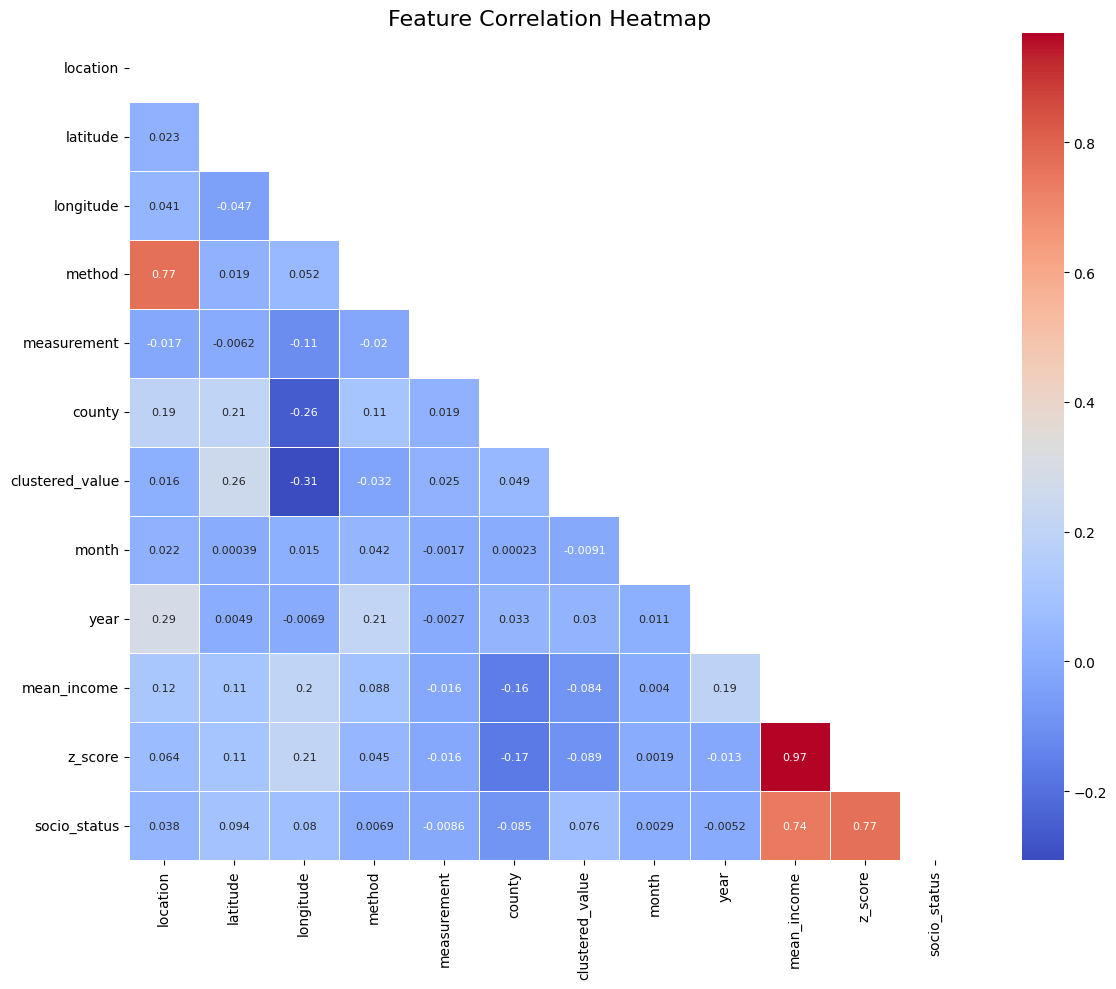

In [ ]:
corr = correlation_analysis(water_quality_encoded)
if isinstance(corr, str):
    display(Markdown(corr))
else:
    display(corr.style.background_gradient(cmap='coolwarm'))
    plot_correlation_heatmap(water_quality_encoded)

In [ ]:
cor_target = abs(corr["mean_income"])
relevant_features = cor_target[cor_target>0]
relevant_features

,mean_income
location,0.115491
latitude,0.105528
longitude,0.204536
method,0.087608
measurement,0.015642
county,0.159927
clustered_value,0.083688
month,0.004046
year,0.192804
mean_income,1.000000


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

In [ ]:
clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_preds = clf.predict(X_test)

In [ ]:
clf.score(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
# Import LinearSVC from sklearn's svm module
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

### YOUR CODE GOES HERE
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
classifiers = {
"ZeroR": DummyClassifier(strategy='most_frequent'),
#"KNN": KNeighborsClassifier(3),
#"SVC" : SVC(),
#"NuSVC": NuSVC(probability=True),
"DecisionTree": DecisionTreeClassifier(class_weight='balanced'),
"RandomForestClassifier": RandomForestClassifier(class_weight='balanced'),
"AdaBoostClassifier": AdaBoostClassifier(),
"GradientBoostingClassifier": GradientBoostingClassifier(),
"GaussianNB": GaussianNB(),
"LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
"QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis()
}

In [ ]:
results = {}

In [ ]:
# Create a more visual confusion matrix
# Import seaborn for improving visualisaztion of confusion matrix
import seaborn as sns

# Make confusion matrix more visual
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot=True, # Annotate the boxes
                    cbar=False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Import precision_score, recall_score and f1_score from sklearn's metrics module
from sklearn.metrics import precision_score, recall_score, f1_score

# Import plot_roc_curve from sklearn's metrics module
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [ ]:
example_results = {}
for model_name, model in classifiers.items():
  print(f"Training using {model_name}")
  model.fit(X_train, y_train)
  clf = model
  y_preds = clf.predict(X_test)
  #plot_conf_mat(y_test, y_preds)
  #print(classification_report(y_test, y_preds))
  f1_score(y_test, y_preds, average='weighted')
  print()
  results[model_name] = model.score(X_test, y_test)

Training using ZeroR

Training using DecisionTree

Training using RandomForestClassifier


In [ ]:
results

{'ZeroR': 0.4290320896106948,
 'KNN': 0.8375283949972584,
 'DecisionTree': 0.9999543069009634,
 'RandomForestClassifier': 0.7481396381106556,
 'AdaBoostClassifier': 0.4290320896106948,
 'GradientBoostingClassifier': 0.7375845322332176,
 'GaussianNB': 0.4187511423274759,
 'LinearDiscriminantAnalysis': 0.43152562730097394,
 'QuadraticDiscriminantAnalysis': 0.287324734327267}

In [ ]:
results_df = pd.DataFrame({
    'Accuracy': results,
    'MSE': mse_errors
})

In [ ]:
ax = results_df['Accuracy'].plot.bar(
    yerr=np.sqrt(results_df['MSE']),  # standard deviation (√MSE) as error bars
    capsize=4,
    color='skyblue',
    figsize=(10, 6),
    title='Model Accuracy with Error Bars (Std Dev)'
)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
results_df = pd.DataFrame(results.values(), results.keys(), columns=['Accuracy'])
plot = results_df.plot.bar()
#plot.set_ylabel("Accuracy")
#plot.bar()

NameError: name 'pd' is not defined

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Setup an instance of RandomizedSearchCV with a LogisticRegression() estimator,
# our log_reg_grid as the param_distributions, a cv of 5 and n_iter of 5.
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}
rs_log_reg = RandomizedSearchCV(estimator=LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=5,
                                verbose=True)

# Fit the instance of RandomizedSearchCV
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': np.float64(0.0018329807108324356)}

In [ ]:
rs_log_reg.score(X_test, y_test)

0.34255034433238685

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} seaborn

/bin/bash: line 1: conda: command not found


In [ ]:
# Import confusion_matrix and classification_report from sklearn's metrics module


In [ ]:
from scipy.stats import chi2_contingency

np.set_printoptions(legacy='1.25')

# Defining a function to perform the Chi-Square Test and interpret results
def perform_chi_square_test(data, col1, col2):
    #import pdb; pdb.set_trace()
    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant

# Additional aspects to test in the Mathematics dataset
additional_aspects_to_test = {
    'Chemical and County corralation': ('characteristic', 'county'),
    'Test_2': ('county', 'characteristic'),
    'Test_3': ('year', 'county'),
    'Test_4': ('result_num', 'county'),
    #'Health Status and Grades': ('health', 'G3')
}
# Performing the additional tests for Mathematics dataset
additional_mat_chi_square_results = {aspect: perform_chi_square_test(water_quality, *columns) for aspect, columns in additional_aspects_to_test.items()}
additional_mat_chi_square_results

KeyError: 'characteristic'

In [ ]:
# Run F-test between each feature and the target
f_scores, p_values = f_regression(X, y)

# Print scores
for i, (score, pval) in enumerate(zip(f_scores, p_values)):
    print(f"Feature_{i}: F-score = {score:.2f}, p-value = {pval:.4f}")

Feature_0: F-score = 155.85, p-value = 0.0000
Feature_1: F-score = 42630.56, p-value = 0.0000
Feature_2: F-score = 63312.82, p-value = 0.0000
Feature_3: F-score = 634.25, p-value = 0.0000
Feature_4: F-score = 95.19, p-value = 0.0000
Feature_5: F-score = 389.71, p-value = 0.0000
Feature_6: F-score = 1497.78, p-value = 0.0000
Feature_7: F-score = 50.86, p-value = 0.0000
Feature_8: F-score = 537.76, p-value = 0.0000


## Statistical Analysis

### Correlation Heatmap between Socioeconomic Data and Water Quality

In [ ]:
plt.figure(figsize=(12, 10))
socioeconomic_cols = ['mean_income', 'z_score', 'socio_status'] if all(col in water_quality.columns for col in ['mean_income', 'z_score', 'socio_status']) else []
quality_cols = ['chemical', 'measurement'] if all(col in water_quality.columns for col in ['chemical', 'measurement']) else []
time_cols = ['year', 'month'] if all(col in water_quality.columns for col in ['year', 'month']) else []

analysis_cols = socioeconomic_cols + quality_cols + time_cols
analysis_cols = [col for col in analysis_cols if col in water_quality.columns]

if analysis_cols:
    correlation = water_quality[analysis_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Socioeconomic Data and Water Quality')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.close()

### Multiple Regression Analysis

In [ ]:
if 'chemical' in water_quality.columns:
  target_chemical = 'chemical'
  predictors_chemical = [col for col in water_quality.columns if col not in ['chemical']]
  predictors_chemical = [col for col in predictors_chemical if water_quality[col].dtype in ['int64', 'float64']]

  formula_chemical = f"{target_chemical} ~ {' + '.join(predictors_chemical)}"
  model_chemical = ols(formula=formula_chemical, data=water_quality).fit()
  print(model_chemical.summary())

  X = water_quality[predictors_chemical]
  vif_data = pd.DataFrame()
  vif_data["Variable"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  print("\nVariance Inflation Factors (VIF):")
  print(vif_data.sort_values('VIF', ascending=False))

  if 'measurement' in water_quality.columns:
    target_measurement = 'measurement'
    predictors_measurement = [col for col in water_quality.columns if col not in ['measurement', 'date']]
    predictors_measurement = [col for col in predictors_measurement if water_quality[col].dtype in ['int64', 'float64']]

    formula_measurement = f"{target_measurement} ~ " + " + ".join(predictors_measurement)
    model_measurement = ols(formula_measurement, data=water_quality).fit()
    print("\nRegression results for measurement amount:")
    print(model_measurement.summary())

                            OLS Regression Results                            
Dep. Variable:               chemical   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     859.0
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:41:52   Log-Likelihood:            -2.3056e+06
No. Observations:              612784   AIC:                         4.611e+06
Df Residuals:                  612771   BIC:                         4.611e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -360.7584      9.406    -

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# One-hot encode the 'chemical' column
if 'chemical' in water_quality.columns:
    chemical_dummies = pd.get_dummies(water_quality['chemical'], prefix='chemical', drop_first=True)
    county_dummies = pd.get_dummies(water_quality['county'], prefix='county', drop_first=True)
    cluster_dummies = pd.get_dummies(water_quality['clustered_value'], prefix='cluster', drop_first=True)

    water_quality_encoded = pd.concat([
        water_quality.drop(['chemical', 'county', 'clustered_value'], axis=1),
        chemical_dummies, county_dummies, cluster_dummies
    ], axis=1)
else:
    water_quality_encoded = water_quality.copy()

# Socio_status regression
if 'socio_status' in water_quality_encoded.columns:
    target_chemical = 'socio_status'
    predictors_chemical = [col for col in water_quality_encoded.columns if col not in ['socio_status']]
    #predictors_chemical = [col for col in predictors_chemical if water_quality_encoded[col].dtype in ['int64', 'float64']]

    print(f"PREDICTORS CHEMICAL: \n\n{predictors_chemical}")

    formula_chemical = f"{target_chemical} ~ {' + '.join(predictors_chemical)}"
    model_chemical = ols(formula=formula_chemical, data=water_quality_encoded).fit()
    print(model_chemical.summary())

    X = water_quality_encoded[predictors_chemical]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data.sort_values('VIF', ascending=False))

# Measurement regression
if 'measurement' in water_quality_encoded.columns:
    target_measurement = 'measurement'
    predictors_measurement = [col for col in water_quality_encoded.columns if col not in ['measurement', 'date']]
    #predictors_measurement = [col for col in predictors_measurement if water_quality_encoded[col].dtype in ['int64', 'float64']]

    formula_measurement = f"{target_measurement} ~ " + " + ".join(predictors_measurement)
    model_measurement = ols(formula_measurement, data=water_quality_encoded).fit()
    print("\nRegression results for measurement amount:")
    print(model_measurement.summary())

PREDICTORS CHEMICAL: 

['location', 'latitude', 'longitude', 'method', 'measurement', 'month', 'year', 'mean_income', 'z_score', 'chemical_1', 'chemical_2', 'chemical_3', 'chemical_4', 'chemical_5', 'chemical_6', 'chemical_7', 'chemical_8', 'chemical_9', 'chemical_10', 'chemical_11', 'chemical_12', 'chemical_13', 'chemical_14', 'chemical_15', 'chemical_16', 'chemical_17', 'chemical_18', 'chemical_19', 'chemical_20', 'chemical_21', 'chemical_22', 'chemical_23', 'chemical_24', 'chemical_25', 'chemical_26', 'chemical_27', 'chemical_28', 'chemical_29', 'chemical_30', 'chemical_31', 'chemical_32', 'chemical_33', 'chemical_34', 'chemical_35', 'chemical_36', 'chemical_37', 'chemical_38', 'chemical_39', 'chemical_40', 'chemical_41', 'chemical_42', 'chemical_43', 'chemical_44', 'chemical_45', 'chemical_46', 'county_1', 'county_2', 'county_3', 'county_4', 'county_5', 'county_6', 'county_7', 'county_8', 'county_9', 'county_10', 'county_11', 'county_12', 'county_13', 'county_14', 'county_15', 'cou

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Time-Series Analysis


Unique chemicals in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


<ipython-input-27-152ed03fc8fe>:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


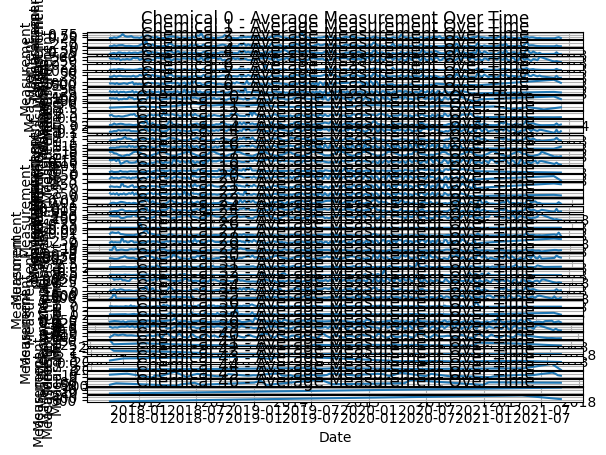

In [ ]:
water_quality['date'] = pd.to_datetime(water_quality[['year', 'month']].assign(day=1))
chemicals = water_quality['chemical'].unique()
print(f"\nUnique chemicals in dataset: {chemicals}")

for i, chem in enumerate(chemicals):
    chem_data = water_quality[water_quality['chemical'] == chem].copy()

    time_series = chem_data.groupby('date')['measurement'].mean().reset_index()
    time_series = time_series.set_index('date')

    plt.subplot(len(chemicals), 1, i+1)
    plt.plot(time_series.index, time_series['measurement'])
    plt.title(f'Chemical {chem} - Average Measurement Over Time')
    plt.ylabel('Measurement')
    if i == len(chemicals) - 1:
        plt.xlabel('Date')
    plt.grid(True)

plt.tight_layout()
plt.savefig('chemical_time_series.png')
plt.show()

### TIme-Series with ARIMA KOUSEI

In [ ]:
try:
    model = ARIMA(ts_chemical, order=(1, 1, 1))
    model_fit = model.fit()
    print("\nARIMA Model Summary for Chemical:")
    print(model_fit.summary())

    # Forecast
    forecast = model_fit.forecast(steps=12)

    # Plot forecast
    plt.figure(figsize=(15, 7))
    plt.plot(ts_chemical.index, ts_chemical.values, label='Observed')

    # Create forecast dates (next 12 periods)
    last_date = ts_chemical.index[-1]
    if isinstance(last_date, pd.Timestamp):
        forecast_idx = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')
    else:
        forecast_idx = range(len(ts_chemical), len(ts_chemical) + 12)

    plt.plot(forecast_idx, forecast, color='red', label='Forecast')
    plt.title('ARIMA Forecast for Chemical Concentration')
    plt.xlabel('Date')
    plt.ylabel('Chemical Concentration')
    plt.legend()
    plt.grid(True)
    plt.savefig('chemical_forecast.png')
    plt.close()
except:
    print("Could not fit ARIMA model - check data quality and stationarity.")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



ARIMA Model Summary for Chemical:
                               SARIMAX Results                                
Dep. Variable:               chemical   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -76.446
Date:                Thu, 24 Apr 2025   AIC                            158.893
Time:                        02:53:14   BIC                            162.166
Sample:                             0   HQIC                           159.664
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1152      0.266      0.432      0.665      -0.407       0.638
ma.L1         -0.5581      0.224     -2.492      0.013      -0.997      -0.119
sigma2        60.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Geospatial Analysis

In [ ]:
center_lat = water_quality['latitude'].mean()
center_lon = water_quality['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

if 'chemical' in water_quality.columns:
        value_col = 'chemical'
elif 'measurement' in water_quality.columns:
    value_col = 'measurement'
else:
    value_col = None

if value_col:
  # Add points to the map
  for _, row in water_quality.iterrows():
      if pd.notna(row['latitude']) and pd.notna(row['longitude']):
          folium.CircleMarker(
              location=[row['latitude'], row['longitude']],
              radius=5,
              color='blue',
              fill=True,
              fill_color='blue',
              fill_opacity=0.7,
              popup=f"{value_col}: {row[value_col]}"
          ).add_to(m)

heat_data = [[row['latitude'], row['longitude'], row[value_col]]
                     for _, row in water_quality.iterrows()
                     if pd.notna(row['latitude']) and pd.notna(row['longitude']) and pd.notna(row[value_col])]
HeatMap(heat_data).add_to(m)
m.save('water_quality_map.html')
print(f"Interactive map saved as 'water_quality_map.html'")

In [ ]:
water_quality_encoded.to_csv('water_quality_encoded.csv', index=False)

NameError: name 'water_quality_encoded' is not defined